# Лабораторная работа по методам Монте-Карло

В рамках данной работы предлагается:
- Реализовать динамику Ланжевена для сэмплирования из апостериорного распределения
- Реализовать стохастическую динамику Ланжевена для сэмплирования из апостериорного распределения
- Применить оба метода на модельной задаче оценки параметров смеси нормальных распределений
- *(бонусная часть)* Применить динамику Ланжевена для генерации изображений

Оценка ставится на основе дополненного кода в ячейках (вычисление градиентов в модельной задаче, динамика Ланжевена и стохастическая динамика Ланжевена), а также ответов на вопросы по экспериментам. В бонусной части задания в качестве ненормированной плотности используется выход сверточной нейронной сети, поэтому для её выполнения вам может потребоваться GPU, облачный сервер или немного терпения.

Полезные источники:

- Welling M., Teh Y. W. Bayesian learning via stochastic gradient Langevin dynamics // Proceedings of the 28th International Conference on Machine Learning (ICML-11). – 2011. – С. 681-688.
- Neal R. M. et al. MCMC using Hamiltonian dynamics // Handbook of Markov Chain Monte Carlo. – 2011. – Т. 2. – №. 11
- Grathwohl W. et al. Your Classifier is Secretly an Energy Based Model and You Should Treat it Like One // ICLR 2020

Критерии оценки:
1. Функции для вычисления плотностей в модельной задаче - 2 балла
2. Стохастическая динамика Ланжевена - 2 балла
3. Динамика Ланжевена - 2 балла
4. Комментарии к экспериментам 1 - 1.5 балл
5. Комментарии к экспериментам 2 - 1.5 балл
6. Комментарии к экспериментам 3 - 1 балл
7. Бонусная часть - 2 балла максимум

In [1]:
# Библиотеки, использованные при разработке задания:
# numpy==1.19.2
# jax==0.2.3
# matplotlib==3.3.2
# tqdm==4.50.2
# torch==1.6.0

import matplotlib.pylab as plt
import numpy as onp
import jax.numpy as np
import jax

import copy
import gzip
import os

from jax.scipy.stats import norm
from tqdm import tqdm

# убираем warning если у вас нет gpu или tpu
jax.config.update('jax_platform_name', 'cpu')
%matplotlib inline

### Пара слов о библиотеках для лабораторной работы

Поскольку для динамики Ланжевена нужны градиенты плотности, в этой работе мы воспользуемся библиотекой JAX для их подсчета. JAX переобределяет большую часть библиотеки numpy в модуле jax.numpy и добавляет возможности для
- Автоматическго построения градиентов функций;

In [2]:
def foo(x):
    return np.sin(x) 

grad_foo = jax.grad(foo)
x = 0.
print("f(0) = {}, f'(0) = {}".format(foo(x), grad_foo(x)))

f(0) = 0.0, f'(0) = 1.0


- Векторизации функций;

In [3]:
# np.cos и так векторизован, но jax.vmap добавлять векторную размерность и для более сложных питоновских функций
vector_grad_foo = jax.vmap(grad_foo)
# vector_grad_foo(0.) теперь не заработает
vector_grad_foo(0.5 * np.pi * np.arange(8))

DeviceArray([ 1.0000000e+00, -4.3711388e-08, -1.0000000e+00,
              1.1924881e-08,  1.0000000e+00, -3.3776624e-07,
             -1.0000000e+00,  6.6360758e-07],            dtype=float32, weak_type=True)

- Выполнения вычислений на ускорителях и компиляции функций "just-in-time"

In [4]:
x = 0.5 * np.pi * np.arange(100)

%timeit vector_grad_foo(x)
vector_grad_foo = jax.jit(vector_grad_foo) # компилируем функцию
%timeit vector_grad_foo(x)
%timeit np.cos(x) # так работает библиотечная функция

4.29 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.55 µs ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.67 µs ± 87.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Модуль jax.numpy можно использовать аналогично библиотеке numpy. Главным исключением является генерация случайных чисел: для этого в jax есть модуль jax.random, о котором можно прочитать [тут](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#%F0%9F%94%AA-Random-Numbers). **Tl;dr: для генерации каждый раз нужно передавать уникальный ключ.**

In [5]:
rng = jax.random.PRNGKey(seed=42)
rng, key = jax.random.split(rng)
n = jax.random.normal(key, (3,))
print('Random sample:\n{}'.format(n))
n = jax.random.normal(key, (3,))
print('Same key, same sample:\n{}'.format(n))
rng, key = jax.random.split(rng)
n = jax.random.normal(key, (3, ))
print('New key, new sample:\n{}'.format(n))

Random sample:
[-0.5675502   0.28439185 -0.9320608 ]
Same key, same sample:
[-0.5675502   0.28439185 -0.9320608 ]
New key, new sample:
[ 0.67903334 -1.220606    0.94670606]


Рекомендуем использовать jax.random при сэмплировании в динамике Ланжевена: он быстрее и "случайней". Тем не менее, для простоты мы будем инициализировать веса с помощью *numpy.random*.

# Задача оценки параметров смеси распределений

> Рассмотрим вероятностную модель, в которой данные приходят из смеси нормальных распределений:

>\begin{align}
& \theta_1 \sim N(0,\sigma_1^2); \quad \theta_2 \sim N(0, \sigma_2^2) \\
& \\
& x_i \overset{i.i.d.}{\sim} \frac{1}{2} N(\theta_1, \sigma_x^2) + \frac{1}{2} N(\theta_1 + \theta_2, \sigma_x^2) \quad i=1,\dots,N \\
\end{align}

>На $\theta_1$ и $\theta_2$ введены априорные нормальные распределения, а все остальные параметры полагаются равными
\begin{align}
& \sigma_x^2 = 2 \\
& \sigma_1^2 = 10 \\
& \sigma_2^2 = 1 \\
\end{align}

>Требуется по сгеренированной с параметрами $\theta_1 = 0$, $\theta_2 = 1$ выборке $X$ из $N=100$ элементов построить сэмплы из апостериорного распределения $p({\bar \theta} | X, \sigma_x, \sigma_1, \sigma_2)$.

Построим выборку из данного распределения:

<ipython-input-7-737d320ee308>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mixture_component = onp.random.randint(0, 2, N).astype(onp.bool)


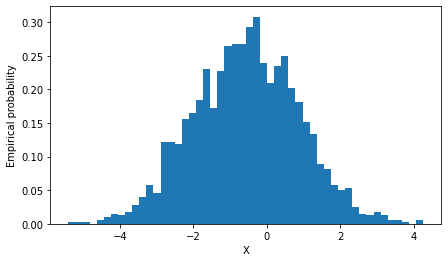

In [7]:
def generate_mixture_data(N, theta_1=None, theta_2=None, seed=6):
    """
    Функция геренирует выобрку данного размера из описанной выше вероятностной модели.
    В случае, когда для theta_1 или theta_2 передано скалярное значение, вместо случайного
    значения параметра из априорного распределения используется переданное значение.
    """
    onp.random.seed(seed)
    sigma_x = np.sqrt(2.)
    if theta_1 is None:
        sigma_1 = np.sqrt(10.)
        theta_1 = sigma_1 * onp.random.randn()
    if theta_2 is None:
        sigma_2 = 1.
        theta_2 = sigma_2 * onp.random.randn()
    mixture_component = onp.random.randint(0, 2, N).astype(onp.bool)
    first_component = theta_1 + sigma_x * onp.random.randn(N)
    second_component = (theta_1 + theta_2) + sigma_x * onp.random.randn(N)
    samples = np.where(mixture_component,
                       first_component,
                       second_component)
    return samples

# Пример выборки из описанной выше модели
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(generate_mixture_data(2048), bins=50, density=True)
ax.set_xlabel('X')
ax.set_ylabel('Empirical probability');

Наша главная цель - по полученной при фиксированных значениях $\theta_1$ и $\theta_2$ выборке построить апостериорное распределение на их значения.

\begin{equation}
p({\bar \theta} | X, \sigma_x, \sigma_1, \sigma_2) \propto \left[ \prod_{i=1}^{N} p(X| {\bar \theta}, \sigma_x) \right] p(\theta | \sigma_1, \sigma_2)
\end{equation}

Хотя задача и допускает аналитический подсчет апостериорного распределения, после раскрытия скобок оно будет представлять из себя смесь $2^N$ нормальных распределений. Поэтому даже для такой простой задачи аналитический вывод может оказаться неэффективным на практике.

Методы Монте-Карло позволяют получить сэмплы из апостериорного распределения. 

> Для наших целей нам понядобятся функции для подсчета плотности априорного распределения и логарифма правдоподобия. Реализуйте их:

In [7]:
def log_p_prior(weights):
    """
    Логарифм плотности априорного распределения.
    Вход:
        weights - вектор из двух вещественных чисел \theta_1, \theta_2
    Выход: число
    """
    ###################
    # Допишите функцию #
    ###################
    #Плотность априорного распределения на параметры - произведение соответствующих нормальных плотностей из формул в условии
    return norm.logpdf(weights[0], loc=0, scale=onp.sqrt(10)) + norm.logpdf(weights[1], loc=0, scale=1.)

def log_p_likelihood(weights, x):
    """
    Возвращает логарифм правдоподобия данных x относительно параметров weights
    Вход:
        weights - вектор из двух вещественных чисел \theta_1, \theta_2,
        x - данные, представленные вектором фиксированной длины
    Выход: число
    """
    ###################
    # Допишите функцию #
    ###################
    return np.log(0.5 * norm.pdf(x, loc=weights[0], scale=onp.sqrt(2)) + 0.5 * norm.pdf(x, loc=weights[0]+weights[1], scale=onp.sqrt(2))).sum(axis=0)

def log_p_joint(weights, x):
    return log_p_likelihood(weights, x) + log_p_prior(weights)

# Определим функцию для градиента и векторизуем обе функции для подсчета по батчу параметров:
grad_log_p_joint = jax.grad(log_p_joint)
# векторизуем только по первому аргументу
log_p_joint = jax.vmap(log_p_joint, (0, None))
grad_log_p_joint = jax.vmap(grad_log_p_joint, (0, None))
# компиляция для ускорения, можете попробовать опустить этот шаг
log_p_joint = jax.jit(log_p_joint)
grad_log_p_joint = jax.jit(grad_log_p_joint)

Согласно задаче, к нам поступает полученная со значениями $\theta_1=0$ и $\theta_2=1$ выборка из ста наблюдений $x_i$.

Изобразим приближенно плотность аспостериорного распределения в зависимости от числа поступивших наблюдений:

<ipython-input-6-f46fe6fe4e49>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mixture_component = onp.random.randint(0, 2, N).astype(onp.bool)


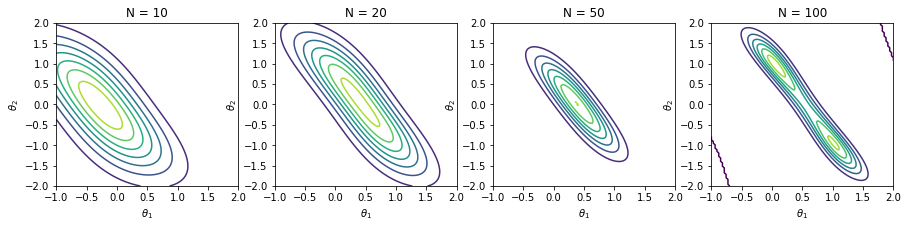

In [8]:
rng = jax.random.PRNGKey(seed=42)
rng, key = jax.random.split(rng)
data = generate_mixture_data(N=100, theta_1=0, theta_2=1)

def plot_posterior(axes, data, resolution=100):
    theta_1 = np.linspace(-1., 2., resolution)
    theta_2 = np.linspace(-2., 2., resolution)
    X, Y = np.meshgrid(theta_1, theta_2)
    weights = np.stack((X.reshape(-1), Y.reshape(-1)), 1)
    log_probs = log_p_joint(weights, data)
    #log_probs = log_probs - log_probs.max() С этой строчкой результат почти такой же (?)
    Z = np.exp(log_probs - log_probs.max())
    norm_const = np.sum(Z) * 3 * 4 / resolution ** 2
    Z /= norm_const
    Z = Z.reshape((resolution, resolution))

    CS = axes.contour(X, Y, Z)
    axes.set_xlabel(r'$\theta_1$')
    axes.set_ylabel(r'$\theta_2$')

Ns = (10, 20, 50, 100,)
fig, axes = plt.subplots(ncols=len(Ns), figsize=(15, 3))
for n, ax in zip(Ns, axes):
    plot_posterior(ax, data[:n])
    ax.set_title('N = %d' % n)

> У апостериорного распределения на последнем графике должны быть две ярко выраженные моды. Чем это можно объяснить?

Если рассмотреть выражение для апостериорного распределения $p({\bar \theta} | X, \sigma_x, \sigma_1, \sigma_2) \propto \left[ \prod_{i=1}^{N} p(X| {\bar \theta}, \sigma_x) \right] p(\theta | \sigma_1, \sigma_2)$, и т. к. $x_i \overset{i.i.d.}{\sim} \frac{1}{2} N(\theta_1, \sigma_x^2) + \frac{1}{2} N(\theta_1 + \theta_2, \sigma_x^2) \quad i=1,\dots,N$, то можно заметить, что в апостериорном распределении будет некоторая симметрия, для конкретного $k$ при всех значениях $\theta_1$ и $\theta_2$, удовлетворяющих условию $2\theta_1+\theta_2=k$ распределения $p(x_i\mid \bar \theta, \sigma_x)$ не будут меняться (их средние останутся равными $k$, дисперсии не изменятся), и значение апостериорной плотности также не изменится. Таким образом, получаемое распределение будет симметрично относительно прямой вида $-0.5\theta_1+\theta_2=m$, перпендикулярной к прямым вида $2\theta_1+\theta_2=k$. Действительно, в данном случае имеем две моды, при $\theta_1=0$, $\theta_2=1$ и при $\theta_1=1$, $\theta_2=-1$, что можно увидеть на графиках. Также интуитивно с ростом числа наблюдений информация о смеси "уточняется", и ее компоненты выделяются более явно. 


> Ниже необходимо реализовать функции для построения сэмплов из апостериорного распределения:

> 1. Стохастическая динамика Ланжевена. Для реализации достаточно слегка модифицировать предложенную реализацию градиентного подъема
> 2. Динамика Ланжевена с приятием точек по схеме Метрополиса-Гастингса
    - Вычисление новых весов
    - Подсчет вероятности их принятия
    - Случайное принятие части весов

In [9]:
def gradient_ascent_update(epsilon, gradient, weights, rng):
    return weights + 0.5 * epsilon * gradient
           
def stochastic_langevin_update(epsilon, gradient, weights, rng):
    """
    Стохастическая динамика Ланжевена
    Вход:
        epsilon - размер шага градиента
        gradient - вещественная матрица с градиентами для пар $\theta$
        weights -  вещественная матрица с параметрами $\theta$
        rng - сид для генерации случайных чисел
    Выход:
        вещественная матрица, соответствующая обновленным параметрам $\theta$
    """
    ###################
    # Допишите функцию #
    ###################
    ## Согласно формулам из https://icml.cc/2011/papers/398_icmlpaper.pdf и конспекту лекций (в дальнейших пунктах - так же по ним)
    return gradient_ascent_update(epsilon, gradient, weights, rng) + jax.random.normal(key=rng, shape=weights.shape) * np.sqrt(epsilon)

def mh_acceptance_ratio(data, epsilon, weights, new_weights):
    """
    Динамика Ланжевена
    Вход:
        epsilon - размер шага градиента
        weights -  вещественная матрица с параметрами $\theta$
        new_weigts - параметры, полученные после шага схемы Ланжевена
    Выход:
        вещественный вектор, задающий логарифм вероятности принятия каждой пары из батча
    """

    ###################
    # Допишите функцию #
    ###################
    #Для удобства немного изменим сигнатуру, добавим возможность подавать выборку в аргументах
    return onp.minimum(log_p_joint(new_weights, data) - log_p_joint(weights, data), 0)
        
def langevin_update(data, epsilon, gradient, weights, rng):
    """
    Динамика Ланжевена
    Вход:
        epsilon - размер шага градиента
        gradient - вещественная матрица с градиентами для пар $\theta$
        weights -  вещественная матрица с параметрами $\theta$
        rng - сид для генерации случайных чисел
    Выход:
        вещественная матрица, соответствующая обновленным параметрам $\theta$
        вещественное число, доля принятых точек из батча
    """
    ###################
    # Допишите функцию #
    ###################
    #Изменим сигнатуру для удобства по аналогии с предыдущей функцией
    new_weights = stochastic_langevin_update(epsilon, gradient, weights, rng)
    A = onp.exp(mh_acceptance_ratio(data, epsilon, weights, new_weights))
    selected_weights_idx = onp.random.binomial(1, A).astype(bool)
    selected_weights = onp.copy(weights)
    selected_weights[selected_weights_idx] = new_weights[selected_weights_idx]
    return selected_weights, onp.mean(selected_weights_idx)

## Динамика Ланжевена на модельной задаче

Для проведения эксперимента определим несколько вспомогательных функций

In [10]:
def append_ema(array, value, alpha=0.05):
    """
    Добавление элементов в массив с экспоненциальным сглаживанием
    """
    if not array:
        array.append(value)
    else:
        array.append((1 - alpha) * array[-1] + alpha * value)
    return array

def train_mixture(data, weights, epsilon, n_epochs=2000, n_trajectories=5):
    """
    Построение точек из апостериорного распределения с помощью динамики Ланжевена
    Параллельно с построением точек сохраняются траектории n_trajectories точек и динамика
    acceptance_rate
    """
    rng = jax.random.PRNGKey(27)
    acceptance_rate = []
    theta_dynamics = []
    for epoch in tqdm(range(n_epochs)):
        theta_dynamics.append(copy.copy(weights[:n_trajectories]))
        gradient = grad_log_p_joint(weights, data)
        rng, key = jax.random.split(rng)
        weights, accepted = langevin_update(data, epsilon, gradient, weights, key)
        append_ema(acceptance_rate, accepted)
    theta_dynamics = np.asarray(theta_dynamics)
    return weights, acceptance_rate, theta_dynamics

Запустим M схем Ланжевена с шагом $\varepsilon = 10^{-3}$ и с шагом $\varepsilon = 10^{-4}$

In [52]:
M = 128

weights_a = onp.random.randn(M, 2)
weights_b = onp.random.randn(M, 2)

weights_a, acceptance_rates_a, theta_dynamics_a = train_mixture(data, weights_a, 1e-3)
weights_b, acceptance_rates_b, theta_dynamics_b = train_mixture(data, weights_b, 1e-4)

100%|██████████| 2000/2000 [00:05<00:00, 334.62it/s]


В следующей ячейке строится четыре графика:
1. Два множества M точек из параллельно запущенных динамик Ланжевена после 2000 итераций
2. Динамика пяти точек из схемы с шагом $\varepsilon=10^{-3}$
3. Динамика пяти точек из схемы с шагом $\varepsilon=10^{-4}$
4. Доля принятых точек (из M параллельных динамик) после каждой итерации для разных шагов

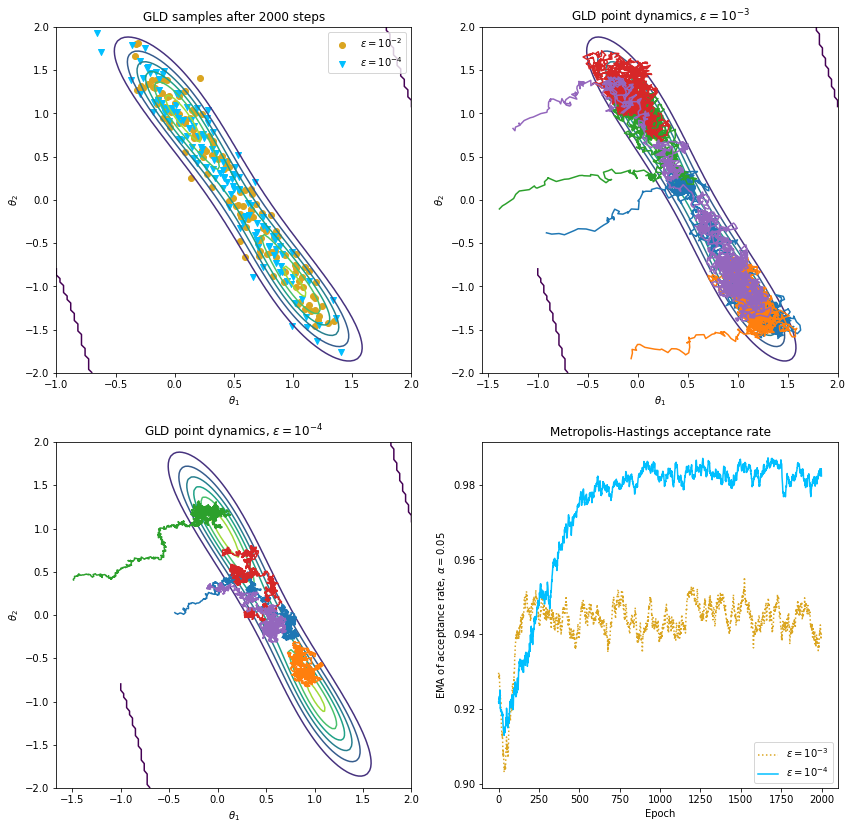

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

plot_posterior(axes[0][0], data)
axes[0][0].scatter(weights_a[..., 0],
                   weights_a[..., 1],
                   marker='o',
                   c='goldenrod',
                   label=r'$\varepsilon=10^{-2}$')
axes[0][0].scatter(weights_b[..., 0],
                   weights_b[..., 1],
                   marker='v',
                   c='deepskyblue',
                   label=r'$\varepsilon=10^{-4}$')
axes[0][0].set_title('GLD samples after 2000 steps')
axes[0][0].legend(loc='upper right')

plot_posterior(axes[0][1], data)
plot_posterior(axes[1][0], data)
axes[0][1].set_title(r'GLD point dynamics, $\varepsilon=10^{-3}$')
axes[1][0].set_title(r'GLD point dynamics, $\varepsilon=10^{-4}$')

for i in range(5):
    axes[0][1].plot(theta_dynamics_a[:, i, 0], theta_dynamics_a[:, i, 1])
    axes[1][0].plot(theta_dynamics_b[:, i, 0], theta_dynamics_b[:, i, 1])

axes[1][1].plot(acceptance_rates_a, label=r'$\varepsilon=10^{-3}$', ls=':', c='goldenrod')
axes[1][1].plot(acceptance_rates_b, label=r'$\varepsilon=10^{-4}$', ls='-', c='deepskyblue')
axes[1][1].set_title('Metropolis-Hastings acceptance rate')
axes[1][1].set_xlabel('Epoch')
axes[1][1].set_ylabel(r'EMA of acceptance rate, $\alpha = 0.05$')
axes[1][1].legend(loc='lower right');

> На основе этих графиков ответьте на следующие вопросы:
- Хорошо ли точки покрывают апостериорное распределение?
- Удается ли точкам "перепрыгнуть" с одной моды на другую?
- Как меняется доля принятых точек в зависимости от величины шага?
- Исходя из каких соображений стоит выбирать длину шага в динамике Ланжевена?

1. В целом полученные точки хорошо покрывают апостериорное распределение. Траектории отдельных динамик покрывают лишь части распределения, и размер этих частей прямопропорционален шагу $\varepsilon$, но в совокупности все траектории и их итоговые принятые точки хорошо и равномерно покрывают апостериорное распределение.

2. Алгоритмам удается при сэмплировании переходить из одной моды в другую, однако во многом это зависит от величины шага $\varepsilon$. Для $\varepsilon=10^{-3}$ видны переходы между модами, и сэмплируемые точки в целом охватывают большие области распределения. Для $\varepsilon=10^{-4}$ же сэмплирование производится преимущественно из одной моды, траектории в целом довольно "скученные" в силу малого размера шага и долго "подходят" к интересующему нас распределению, и для перехода в другую моду при малом шаге алгоритму нужно большее число итераций.

3. При меньшем размере шага $\varepsilon=10^{-4}$ доля принятых точек дольше возрастает и стабилизируется около единицы, что соответствует малому размеру шага и сосредоточению в одной моде. Для $\varepsilon=10^{-3}$ первые 200 эпох доля возрастает сильнее, однако затем начинает колебаться в районе 0.94, что соответствует более далеким и частым переходам, в том числе и в другие моды. В целом при меньшей величине шага в большей степени сэмплирование будет происходить из одной области компоненты смеси, и доля принятых точек будет выше.

4. В принципе больший размер шага $\varepsilon$ соответвтует большему покрытию распределения и пространства в целом траекторией, повышает вероятность перехода между модами. Однако подбор шага может зависеть от формы рассматриваемого распределения, из которого хотим сэмплировать, а также и от значений и нормы градиентов. Можно подбирать шаг экспериментально, оценив результаты при разных $\varepsilon$ и выбрав наилучший, или адаптивно подбирать величину шага в зависимости от градиента или вероятности принятия точки.

## Стохастическая динамика Ланжевена на модельной задаче

Для проведения следующего эксперимента определим еще несколько вспомогательных функций

In [11]:
# стохастическая оценка совместного правдоподобия
def log_p_joint_estimate(weights, x, N_over_n):
    return N_over_n * log_p_likelihood(weights, x) + log_p_prior(weights)
# стохастический градиент
grad_log_p_joint_estimate = jax.grad(log_p_joint_estimate)

log_p_joint_estimate = jax.jit(jax.vmap(log_p_joint_estimate, (0, None, None)))
grad_log_p_joint_estimate = jax.jit(jax.vmap(grad_log_p_joint_estimate, (0, None, None)))

# определим вектор градиентов $\nablda log p(x_i), i=1, \dots, N$ для подсчета дисперсии относительно выбора данных
batch_gradients = jax.vmap(jax.grad(log_p_likelihood), (None, 0))

In [12]:
def iterate_data(rng, length, batchsize=100, shuffle=True):
    """
    Функция для прохода по выборке
    """
    indices = onp.arange(length)
    if shuffle:
        onp.random.shuffle(indices)
    for start_idx in range(0, length - batchsize + 1, batchsize):
        yield indices[start_idx:start_idx + batchsize]

def stochastic_train_mixture(rng, data, weights, method, n_epochs=2000, n=10, n_trajectories=5):
    """
    Построение точек из апостериорного распределения с помощью стохастической динамики Ланжевена
    Параллельно с построением точек сохраняются траектории n_trajectories точек после каждой эпохи,
    оценки дисперий стохастического градиента и дисперсия добавочного шума динамики Ланжевена
    """
    noise_vars = []
    theta_vars = []
    theta_dynamics = []
    N_over_n = len(data) / n
    steps_counter = 0
    for epochs in tqdm(range(n_epochs)):
        epsilon = 1e-1 * (steps_counter + 1e1) ** (-0.55)
        rng, key = jax.random.split(rng)
        for indices in iterate_data(key, len(data), n):
            rng, key = jax.random.split(rng)
            gradient = grad_log_p_joint_estimate(weights, data[indices], N_over_n)
            weights = method(epsilon, gradient, weights, key)
            steps_counter += 1
    
        theta_dynamics.append(copy.copy(weights[:n_trajectories, :]))
        # также как и в статье, оцениваем дисперсии по подвыборке
        rng, key = jax.random.split(rng)
        theta_grad = batch_gradients(weights, data)
        theta_vars.append(theta_grad.var(0).max(0) * (0.5 * epsilon * N_over_n) ** 2 * n)
        noise_vars.append(epsilon)
        
    theta_dynamics = np.asarray(theta_dynamics)
    theta_vars = np.asarray(theta_vars)
    noise_vars = np.asarray(noise_vars)
    
    return weights, noise_vars, theta_vars, theta_dynamics

Запустим стохастическую динамику Ланжевена и стохастический градиентный подъем

In [13]:
M = 128
n = 10
n_trajectories = 5

weights_a = onp.random.randn(M, 2)
weights_b = onp.random.randn(M, 2)

weights_a, noise_vars_a, theta_vars_a, theta_dynamics_a = stochastic_train_mixture(
    rng, data, weights_a, stochastic_langevin_update, n_epochs=200
)

weights_b, _, theta_vars_b, theta_dynamics_b = stochastic_train_mixture(
    rng, data, weights_b, gradient_ascent_update, n_epochs=200
)

100%|██████████| 200/200 [00:09<00:00, 20.09it/s]


В следующей ячейке строятся четыре графика:

1. M точек из параллельно запущенных динамик Ланжевена после 2000 эпох и M точек из параллельно замущенных стохастических градиентных спусков после 2000 эпох
2. Траектории пяти точек при движении согласно стохастической динамике Ланжевена
3. Траектории пять точек при движении в направлении стохастического градиента
4. Дисперсии стохастических градиентов и добавочного шума стохастической динамики Ланжевена в зависимости от эпохи

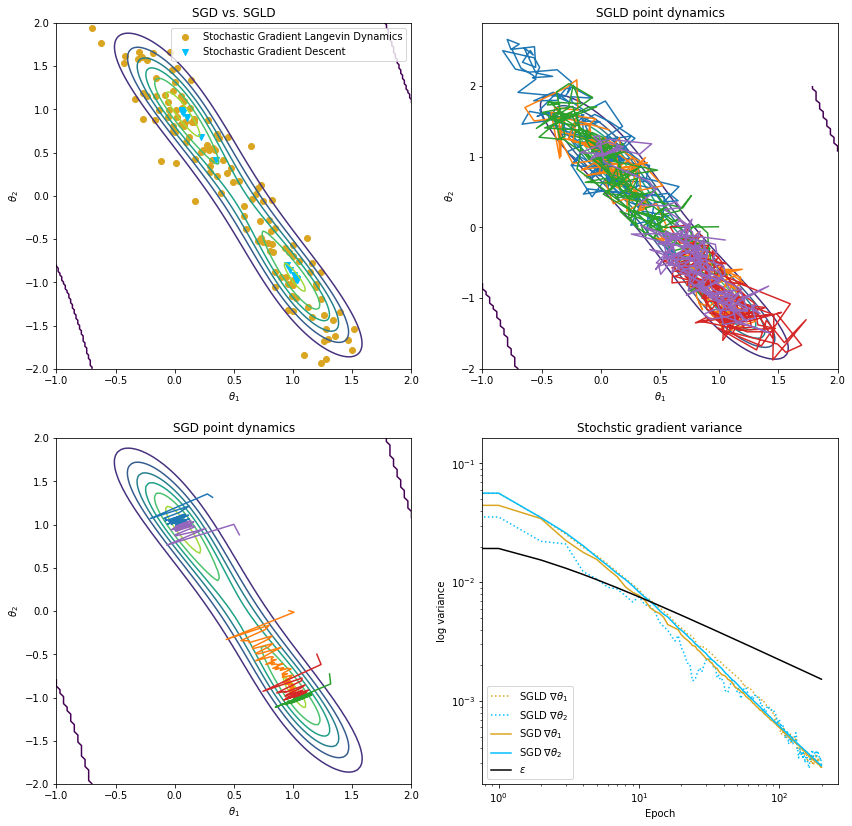

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

plot_posterior(axes[0][0], data, 200)
axes[0][0].scatter(weights_a[:, 0],
                   weights_a[:, 1],
                   c='goldenrod',
                   label='Stochastic Gradient Langevin Dynamics')
axes[0][0].scatter(weights_b[:, 0],
                   weights_b[:, 1],
                   marker='v',
                   c='deepskyblue',
                   label='Stochastic Gradient Descent')
axes[0][0].set_title('SGD vs. SGLD')
axes[0][0].legend(loc='upper right')

plot_posterior(axes[0][1], data)
plot_posterior(axes[1][0], data)
axes[0][1].set_title(r'SGLD point dynamics')
axes[1][0].set_title(r'SGD point dynamics')

for i in range(5):
    axes[0][1].plot(theta_dynamics_a[:, i, 0], theta_dynamics_a[:, i, 1])
    axes[1][0].plot(theta_dynamics_b[:, i, 0], theta_dynamics_b[:, i, 1])

axes[1][1].set_title('Stochstic gradient variance')
axes[1][1].set_yscale("log", nonpositive='clip')
axes[1][1].set_xscale("log", nonpositive='clip')
axes[1][1].plot(theta_vars_a[:, 0], label=r'SGLD $\nabla \theta_1$', c='goldenrod', ls=':')
axes[1][1].plot(theta_vars_a[:, 1], label=r'SGLD $\nabla \theta_2$', c='deepskyblue', ls=':')
axes[1][1].plot(theta_vars_b[:, 0], label=r'SGD $\nabla \theta_1$', c='goldenrod', ls='-')
axes[1][1].plot(theta_vars_b[:, 1], label=r'SGD $\nabla \theta_2$', c='deepskyblue', ls='-')
axes[1][1].plot(noise_vars_a, label=r'$\varepsilon$', c='black')
axes[1][1].set_xlabel('Epoch')
axes[1][1].set_ylabel('log variance')
axes[1][1].legend(loc='lower left');

> На основе графиков ответьте на следующие вопросы:
1. Хорошо ли представленные точки покрывают апостериорное распределение? Где собираются точки после градиентного подъема?
3. Удается ли стохастической динамике Ланжевена "перепрыгнуть" с одной моды на другую?
4. Как соотносятся дисперсии стохастических градиентов с дисперсией добавленного шума динамики Ланжевена?

1. Точки так же хорошо покрывают апостериорное распределение, однако немного сильнее разбросаны по сравнению с обычной динамикой Ланжевена. После градиентного подъема точки собираются в районах максимумов плотностей, около мод распределения.

2. Траектории в стохастической динамике Ланжевена более хаотичны и охватывают области большего размера, в них заметно чаще наблюдаются переходы между модами, чем для стандартной динамики Ланжевена.

3. Дисперсии стохастических градиентов изначально больше, чем дисперсия добавленного шума динамики Ланжевена, однако они убывают сильнее ее и в итоге становятся значительно меньше. В целом дисперсии SGD и SGLD достаточно близки друг к другу.

# Бонусная часть

В работе "Your Classifier is Secretly an Energy Based Model and You Should Treat it Like One" авторы предлагают приближать ненормированную плотность $\hat{p}(x, y)$ данных CIFAR-10 с помощью нейронной сети, разработанной для дискриминативной классификации. Обученная ими модель оказывается одновременно применима и для классификации, и для генерации данных. Для последнего как раз нужна схема Ланжевена.

В этой части задания мы предлагаем реализовать схему для сэмплирования из предобученной модели, выложенной [в репозитории авторов](https://github.com/wgrathwohl/JEM/). Там также можно найти приближенную схему сэмплирования: без поправки Метрополиса-Гастингса и с несогласованными множителями перед градиентом и добавочным шумом.

Попробуйте реализовать максимально обоснованную схему сэмплирования и получить сэмплы из CIFAR-10. Подумайте как выбор начальных точек влияет на скорость сэмплирования? Насколько хорошо определена плотность для аргумнетов, не похожих на изображения из CIFAR-10? Как реализовать условную и безусловную генерацию?

Для удобства к заданию мы прикладываем скрипт, позволяющий загрузить предобученную модель, вычислить значение логарифма ненормированной плотности и градиентов плотности по входному изображению. Пример их использования дан ниже.

In [ ]:
from wideresnet import load_pretrained_model, get_grads_wrt_input
path_to_pretrained_model = "./CIFAR10_MODEL.pt"
model = load_pretrained_model(path_to_pretrained_model)

batch_size = 4
x = onp.random.randn(batch_size, 3, 32, 32)
y = onp.random.randint(10, size=(batch_size, ))

log_p, input_grads = get_grads_wrt_input(model, x)
log_p, input_grads = get_grads_wrt_input(model, x, y)